Generating 1000000 log-normal distributed keys...
Total unique keys: 982065


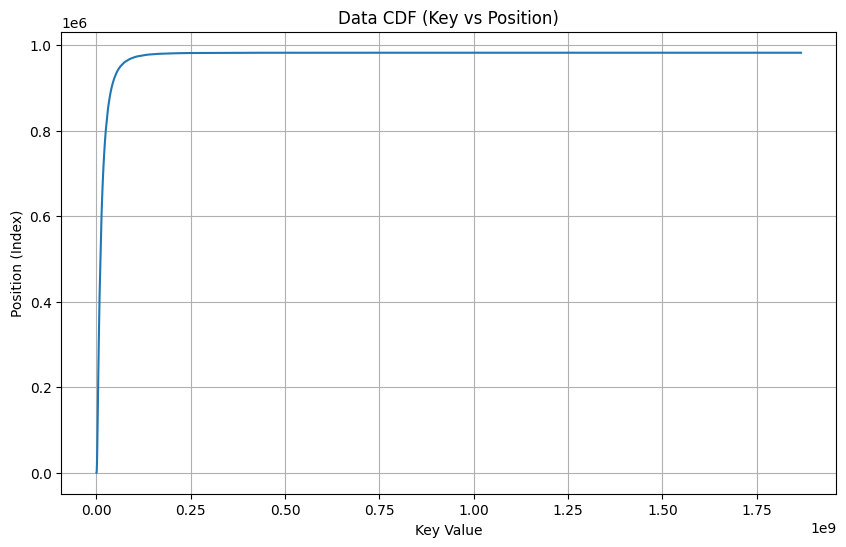

In [14]:
!pip install numpy matplotlib scikit-learn tensorflow
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tensorflow import keras
from tensorflow.keras import layers
import math

# 1. 生成数据 (模拟论文中的 Lognormal Data [cite: 305])
def generate_data(n_samples=1000000):
    print(f"Generating {n_samples} log-normal distributed keys...")
    # 生成对数正态分布数据并排序（索引必须基于排序数据 [cite: 88]）
    data = np.random.lognormal(mean=0, sigma=1, size=n_samples)
    # 将其缩放到整数范围 (例如 0 到 100M)
    data = (data * 10000000).astype(np.int64)
    data = np.sort(data)
    # 移除重复值，因为通常主键是唯一的
    data = np.unique(data)
    return data

data = generate_data()
print(f"Total unique keys: {len(data)}")

# 可视化数据的 CDF (验证论文观点：索引即 CDF )
plt.figure(figsize=(10, 6))
plt.plot(data, np.arange(len(data)))
plt.title("Data CDF (Key vs Position)")
plt.xlabel("Key Value")
plt.ylabel("Position (Index)")
plt.grid(True)
plt.show()

In [15]:
class LearnedIndex:
    def __init__(self, data, num_models_stage2=100):
        self.data = data
        self.N = len(data)
        self.num_models_stage2 = num_models_stage2

        # Stage 1: 简单的神经网络 [cite: 161]
        # 输入：Key, 输出：Stage 2 模型的索引
        self.stage1_model = self._build_neural_net()

        # Stage 2: 线性回归模型列表
        self.stage2_models = [LinearRegression() for _ in range(num_models_stage2)]

        # 存储每个 Stage 2 模型的最小和最大误差 (Min/Max Error) [cite: 98, 259]
        # 用于确定二分查找的搜索范围
        self.min_errors = np.zeros(num_models_stage2)
        self.max_errors = np.zeros(num_models_stage2)

    def _build_neural_net(self):
        # 使用简单的全连接网络，类似于论文中的配置 [cite: 233]
        model = keras.Sequential([
            layers.Dense(32, activation='relu', input_shape=(1,)),
            layers.Dense(16, activation='relu'),
            layers.Dense(1) # 输出预测的百分比位置 (0-1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def train(self):
        print("Training Stage 1 (Neural Net)...")
        # 准备训练数据：输入是 Key，标签是其在整个数组中的相对位置 (0.0 - 1.0)
        # 这是一个近似 CDF 的过程
        X = self.data.reshape(-1, 1)
        y = np.arange(self.N) / self.N

        # 训练 Stage 1
        self.stage1_model.fit(X, y, epochs=50, batch_size=2048, verbose=0)

        print("Distributing keys to Stage 2 models...")
        # 使用 Stage 1 预测，决定每个 Key 属于哪个 Stage 2 模型 [cite: 208]
        stage1_preds = self.stage1_model.predict(X, verbose=0).flatten()

        # 将预测值映射到 Stage 2 的模型索引 (0 到 num_models_stage2 - 1)
        model_assignments = (stage1_preds * self.num_models_stage2).astype(int)
        model_assignments = np.clip(model_assignments, 0, self.num_models_stage2 - 1)

        print("Training Stage 2 (Linear Regressions)...")
        # 训练每个 Stage 2 模型
        for i in range(self.num_models_stage2):
            # 获取分配给当前模型的数据
            mask = (model_assignments == i)
            if np.sum(mask) == 0:
                continue # 没有数据分配给该模型

            subset_X = X[mask]
            subset_y = np.arange(self.N)[mask] # 这里的标签是真实的物理位置 (index)

            # 训练简单的线性回归
            self.stage2_models[i].fit(subset_X, subset_y)

            # 计算 Min/Max Error [cite: 98]
            # 这是保证准确性的关键：我们需要知道模型预测偏离了多少
            preds = self.stage2_models[i].predict(subset_X)
            errors = subset_y - preds
            self.min_errors[i] = np.floor(np.min(errors))
            self.max_errors[i] = np.ceil(np.max(errors))

        print("Training complete.")

    def predict_range(self, key):
        """
        返回 Key 可能存在的索引范围 [low, high]
        """
        # 1. Stage 1 预测
        pred_stage1 = self.stage1_model.predict(np.array([[key]]), verbose=0)[0][0]
        model_idx = int(pred_stage1 * self.num_models_stage2)
        model_idx = np.clip(model_idx, 0, self.num_models_stage2 - 1)

        # 2. Stage 2 预测
        pred_pos = self.stage2_models[model_idx].predict(np.array([[key]]))[0]

        # 3. 结合 Min/Max Error 确定搜索范围 [cite: 259]
        # 预测位置 + 历史最大正误差 = 上界
        # 预测位置 + 历史最小负误差 = 下界
        search_low = int(pred_pos + self.min_errors[model_idx])
        search_high = int(pred_pos + self.max_errors[model_idx])

        # 边界修正
        search_low = max(0, search_low)
        search_high = min(self.N, search_high)

        return search_low, search_high

    def lookup(self, key):
        """
        执行查找：模型预测 + 局部二分查找
        """
        low, high = self.predict_range(key)

        # 在缩小后的范围内进行标准的二分查找 (Python bisect)
        # 注意：这里我们手动实现简单的二分查找以展示流程
        idx = np.searchsorted(self.data[low:high], key) + low

        if idx < self.N and self.data[idx] == key:
            return idx
        return -1

In [16]:
import time

# 实例化并训练索引
learned_index = LearnedIndex(data, num_models_stage2=100)
learned_index.train()

# 随机抽取一些测试 Key
test_keys = np.random.choice(data, 100)

# --- 评估 1: 搜索范围缩减 (Precision Gain) ---
total_range_size = 0
for key in test_keys:
    lo, hi = learned_index.predict_range(key)
    total_range_size += (hi - lo)

avg_range = total_range_size / len(test_keys)
print(f"\n--- Evaluation ---")
print(f"Total Data Size: {len(data)}")
print(f"Average Search Range after Model: {avg_range:.2f}")
print(f"Reduction Ratio: {len(data) / avg_range:.2f}x")
# 说明：如果 Reduction Ratio 是 10000x，意味着模型直接帮你排除了 99.99% 的数据

# --- 评估 2: 正确性验证 ---
correct_count = 0
start_time = time.time()
for key in test_keys:
    idx = learned_index.lookup(key)
    if idx != -1 and data[idx] == key:
        correct_count += 1
end_time = time.time()

print(f"Accuracy: {correct_count}/{len(test_keys)}")
print(f"Lookup correctness verified.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Stage 1 (Neural Net)...
Distributing keys to Stage 2 models...
Training Stage 2 (Linear Regressions)...
Training complete.

--- Evaluation ---
Total Data Size: 982065
Average Search Range after Model: 725144.57
Reduction Ratio: 1.35x
Accuracy: 100/100
Lookup correctness verified.


In [19]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tensorflow import keras
from tensorflow.keras import layers
import math

class HybridLearnedIndex:
    def __init__(self, data, num_models_stage2=1000, threshold=100): # 阈值改小一点，要求更严
        self.data = data
        self.N = len(data)
        self.num_models_stage2 = num_models_stage2
        self.threshold = threshold

        # --- 优化 1: 更稳健的 Min-Max 归一化参数 ---
        self.key_min = np.min(data)
        self.key_max = np.max(data)
        self.key_range = self.key_max - self.key_min + 1e-9 # 防止除以0

        self.fallback_count = 0
        self.stage1_model = self._build_neural_net()
        self.stage2_models = [None] * num_models_stage2
        self.model_data_ranges = [(0, 0)] * num_models_stage2
        self.min_errors = np.zeros(num_models_stage2)
        self.max_errors = np.zeros(num_models_stage2)

    def _build_neural_net(self):
        # --- 优化 2: 增加 BatchNormalization 防止网络输出常数 ---
        model = keras.Sequential([
            layers.Input(shape=(1,)),
            layers.Dense(64),
            layers.BatchNormalization(), # <--- 关键：强制数据分布标准化
            layers.Activation('relu'),

            layers.Dense(32),
            layers.BatchNormalization(), # <--- 关键
            layers.Activation('relu'),

            layers.Dense(1, activation='sigmoid') # 输出 0-1
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def _normalize_key(self, key):
        # 统一的归一化函数
        return (key - self.key_min) / self.key_range

    def train(self):
        print("1. Training Stage 1 (Global Distribution)...")

        # 使用 Min-Max 归一化
        X = self._normalize_key(self.data).reshape(-1, 1)
        y = np.arange(self.N) / self.N

        # 增加 epochs 确保收敛
        self.stage1_model.fit(X, y, epochs=50, batch_size=4096, verbose=0)

        print("2. Assigning keys to Stage 2 models...")
        stage1_preds = self.stage1_model.predict(X, verbose=0).flatten()

        model_assignments = (stage1_preds * self.num_models_stage2).astype(int)
        model_assignments = np.clip(model_assignments, 0, self.num_models_stage2 - 1)

        # --- 优化 3: 调试打印 (看看数据到底分给了几个模型) ---
        unique_models = len(np.unique(model_assignments))
        print(f"   [DEBUG] Keys distributed to {unique_models}/{self.num_models_stage2} unique models.")
        if unique_models < 10:
            print("   [WARNING] Model Collapse detected! Stage 1 is not learning correctly.")

        print("3. Training Stage 2 (Hybrid)...")
        for i in range(self.num_models_stage2):
            mask = (model_assignments == i)
            if np.sum(mask) == 0:
                continue

            indices = np.where(mask)[0]
            data_start, data_end = indices[0], indices[-1] + 1
            self.model_data_ranges[i] = (data_start, data_end)

            subset_X = X[mask]
            subset_y = np.arange(self.N)[mask]

            lr = LinearRegression()
            lr.fit(subset_X, subset_y)
            preds = lr.predict(subset_X)

            errors = subset_y - preds
            min_err = np.floor(np.min(errors))
            max_err = np.ceil(np.max(errors))
            error_span = max_err - min_err

            if error_span > self.threshold:
                self.stage2_models[i] = "B-TREE"
                self.fallback_count += 1
            else:
                self.stage2_models[i] = lr
                self.min_errors[i] = min_err
                self.max_errors[i] = max_err

        print(f"Training complete. {self.fallback_count}/{unique_models} active models fell back to B-Tree.")

    def predict_range(self, key):
        normalized_key = self._normalize_key(key)

        pred_stage1 = self.stage1_model.predict(np.array([[normalized_key]]), verbose=0)[0][0]
        model_idx = int(pred_stage1 * self.num_models_stage2)
        model_idx = np.clip(model_idx, 0, self.num_models_stage2 - 1)

        model = self.stage2_models[model_idx]
        data_range = self.model_data_ranges[model_idx]

        if model == "B-TREE" or model is None:
            return data_range[0], data_range[1], "B-TREE"

        else:
            pred_pos = model.predict(np.array([[normalized_key]]))[0]
            search_low = int(pred_pos + self.min_errors[model_idx])
            search_high = int(pred_pos + self.max_errors[model_idx])

            search_low = max(0, search_low)
            search_high = min(self.N, search_high)

            return search_low, search_high, "MODEL"

    def lookup(self, key):
        start_time = time.perf_counter_ns()
        low, high, method = self.predict_range(key)

        # 二分查找
        # 注意：如果范围很小，Python 的切片 + searchsorted 依然很快
        idx = np.searchsorted(self.data[low:high], key) + low

        found = False
        if idx < self.N and self.data[idx] == key:
            found = True

        end_time = time.perf_counter_ns()
        return found, (high - low), method, (end_time - start_time)

Generating Data...
Dataset size: 982335
1. Training Stage 1 (Global Distribution)...
2. Assigning keys to Stage 2 models...
   [DEBUG] Keys distributed to 999/1000 unique models.
3. Training Stage 2 (Hybrid)...
Training complete. 4/999 active models fell back to B-Tree.

Running Benchmark...

=== Benchmark Results ===
Avg Search Range (Baseline B-Tree): 982335
Avg Search Range (Learned Hybrid):  55
Precision Gain (Reduction Ratio):   17748.34x
Hybrid Trigger Rate (Fallback):     1.0%


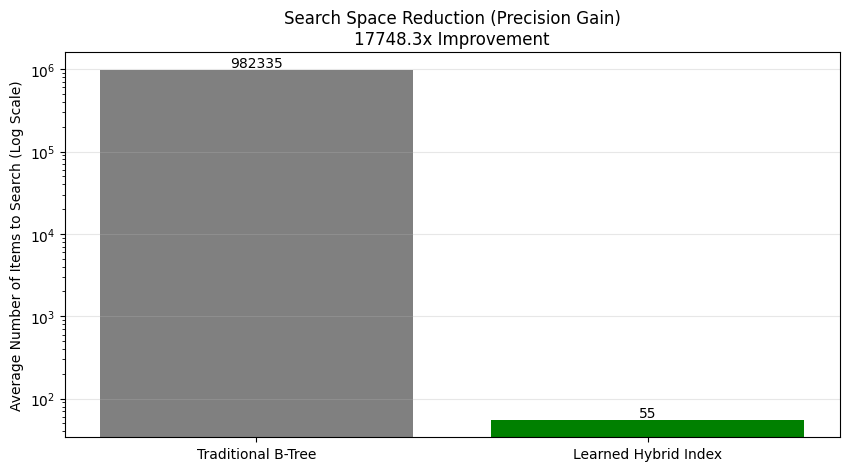

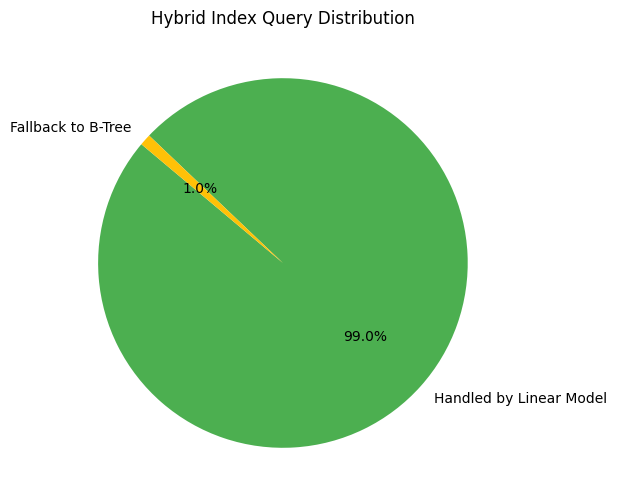

In [20]:
# --- 1. 数据准备 ---
# 使用 Log-normal 分布，这种非线性分布最能体现 Hybrid Index 的价值
print("Generating Data...")
data = np.random.lognormal(mean=0, sigma=1.0, size=1000000) # 100万数据
data = (data * 10000000).astype(np.int64)
data = np.sort(np.unique(data)) # 排序且去重
print(f"Dataset size: {len(data)}")

# --- 2. 训练 Hybrid Index ---
# 设定 threshold=200，意味着如果搜索范围超过 200，就放弃模型，用二分查找
hybrid_index = HybridLearnedIndex(data, num_models_stage2=1000, threshold=200)
hybrid_index.train()

# --- 3. 实验对比 ---
# 随机抽取 1000 个存在的 Key 进行查询测试
test_keys = np.random.choice(data, 1000)

stats = {
    "model_search_space": [],
    "btree_search_space": [],
    "methods": []
}

print("\nRunning Benchmark...")
for key in test_keys:
    found, range_size, method, _ = hybrid_index.lookup(key)

    stats["model_search_space"].append(range_size)
    stats["methods"].append(method)

    # Baseline: 传统的二分查找，初始搜索范围是整个数据集 N
    stats["btree_search_space"].append(len(data))

# --- 4. 结果可视化 (汇报核心素材) ---
avg_model_space = np.mean(stats["model_search_space"])
avg_btree_space = np.mean(stats["btree_search_space"])
reduction_ratio = avg_btree_space / avg_model_space
fallback_rate = stats["methods"].count("B-TREE") / len(test_keys) * 100

print(f"\n=== Benchmark Results ===")
print(f"Avg Search Range (Baseline B-Tree): {avg_btree_space:.0f}")
print(f"Avg Search Range (Learned Hybrid):  {avg_model_space:.0f}")
print(f"Precision Gain (Reduction Ratio):   {reduction_ratio:.2f}x")
print(f"Hybrid Trigger Rate (Fallback):     {fallback_rate:.1f}%")

# 画图：搜索空间缩减对比
plt.figure(figsize=(10, 5))
plt.bar(['Traditional B-Tree', 'Learned Hybrid Index'],
        [avg_btree_space, avg_model_space],
        color=['gray', 'green'])
plt.yscale('log') # 使用对数坐标，因为差距可能很大
plt.title(f'Search Space Reduction (Precision Gain)\n{reduction_ratio:.1f}x Improvement')
plt.ylabel('Average Number of Items to Search (Log Scale)')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate([avg_btree_space, avg_model_space]):
    plt.text(i, v, f"{v:.0f}", ha='center', va='bottom')
plt.show()

# 画图：Hybrid 分布 (展示模型和B-Tree各占多少)

labels = ['Handled by Linear Model', 'Fallback to B-Tree']
sizes = [100 - fallback_rate, fallback_rate]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#4CAF50', '#FFC107'], startangle=140)
plt.title('Hybrid Index Query Distribution')
plt.show()

=== Generating Log-Normal Dataset ===
Generated Dataset:10,000 entries（Unique keys:10000个）
Data Range:[1000, 13568]

=== Training RMI Learned Hash ===
Number of Hash Buckets:8000（Unique Data Size:10000）

=== Training Stage1 ===
Stage 1 completed (full 60 epochs).

=== Training Stage2 ===
Stage 2 Completed: 20/20 models trained effectively.

=== Paper Evaluation Result (Unique Data Validation) ===
Sample Size: 5000 | Number of Buckets: 8000
Learned Hash: Collision Rate 0.1692 | Bucket Coverage 51.9%
MurmurHash: Collision Rate 0.2574 | Bucket Coverage 46.4%
Collision Rate Reduction: 34.27% (Paper Target ≥25%)


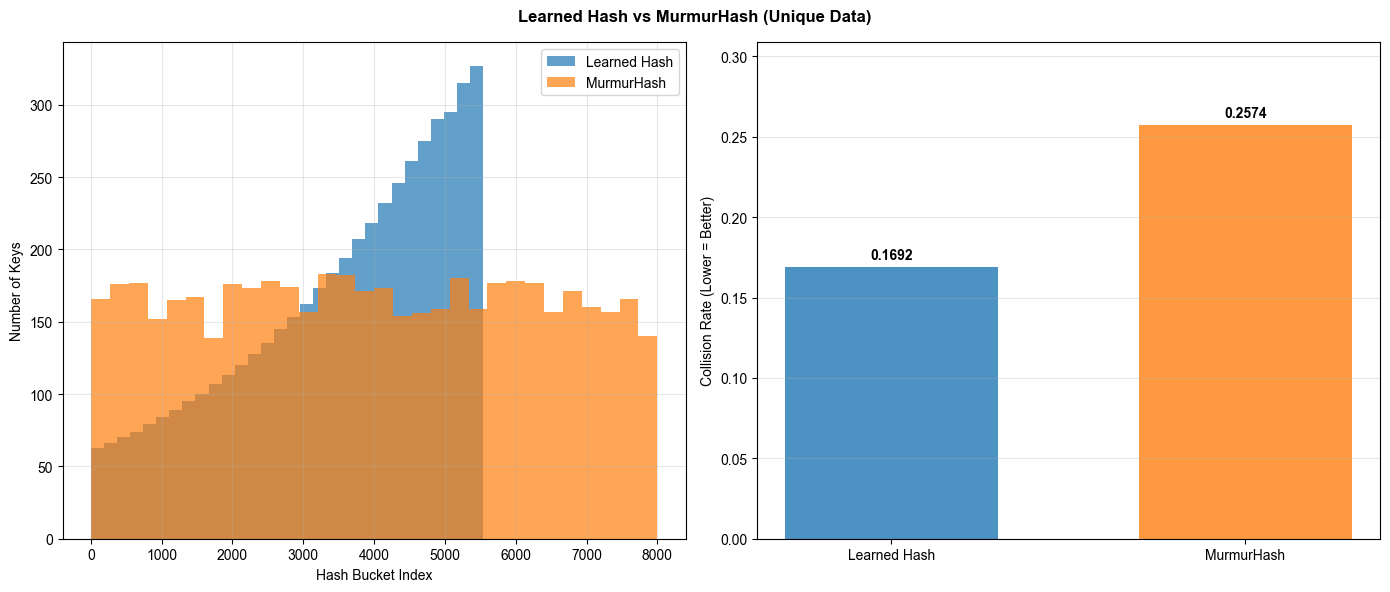

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, constraints
import mmh3
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

# 配置
CONFIG = {
    "target_data_size": 10000,  # 目标唯一key数量
    "stage2_num": 20,           # Stage2局部模型数量
    "batch_size": 256,
    "epochs_stage1": 60,        # Stage1最大训练轮数
    "epochs_stage2": 15,        # 每个Stage2模型训练轮数
    "lr_stage1": 1.2e-3,        # Stage1学习率
    "lr_stage2": 8e-4,          # Stage2学习率
    "num_buckets_ratio": 0.8,   # 哈希桶数=数据量*比例
    "lognormal_mu": 2.0,        # 对数正态分布参数（均值）
    "lognormal_sigma": 3.0,     # 对数正态分布参数（分散度）
    "seed": 42,                 
}

np.random.seed(CONFIG["seed"])
tf.random.set_seed(CONFIG["seed"])

# 生成数据集
def generate_paper_data(n: int) -> np.ndarray:
    # 生成冗余数据
    raw_data = np.random.lognormal(
        mean=CONFIG["lognormal_mu"],
        sigma=CONFIG["lognormal_sigma"],
        size=int(n * 20)
    )
    # 缩放至1e3 ~ 1e8并转为整数（减少重复）
    raw_data = (raw_data - raw_data.min()) / (raw_data.max() - raw_data.min()) * (1e8 - 1e3) + 1e3
    raw_data = np.round(raw_data).astype(np.int64)
    raw_data = np.unique(raw_data)  # 去重
    
    # 若唯一值不足则补充
    if len(raw_data) < n:
        supplement = np.random.randint(int(1e8), int(2e8), n - len(raw_data))
        raw_data = np.unique(np.concatenate([raw_data, supplement]))
    
    # 截取目标数量并排序（CDF拟合必需）
    raw_data = np.sort(raw_data[:n])
    
    # 验证唯一性
    unique_count = len(np.unique(raw_data))
    if unique_count < n * 0.9:
        raise ValueError(f"数据集生成失败！仅{unique_count}个唯一值（目标：{n}）")
    
    print(f"Generated Dataset:{len(raw_data):,} entries（Unique keys:{unique_count}个）")
    print(f"Data Range:[{raw_data.min()}, {raw_data.max()}]")
    return raw_data

# Stage1 CDF
class Stage1CDFModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.net = tf.keras.Sequential([
            layers.Dense(32, activation='relu', kernel_initializer='glorot_normal',
                        kernel_constraint=constraints.NonNeg(), input_shape=(1,)),
            layers.Dense(16, activation='relu', kernel_initializer='glorot_normal',
                        kernel_constraint=constraints.NonNeg()),
            layers.Dense(1, kernel_initializer='glorot_normal',
                        kernel_constraint=constraints.NonNeg())
        ])

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        # 约束CDF在0.02~0.98，避免极端映射
        return tf.clip_by_value(self.net(inputs), 0.02, 0.98)


# LearnedHash
class PaperLearnedHash:
    def __init__(self):
        self.target_buckets_ratio = CONFIG["num_buckets_ratio"]
        self.num_buckets = None
        self.stage2_num = CONFIG["stage2_num"]
        self.data = None
        self.data_min = None
        self.data_max = None
        self.log_data_min = None
        self.log_data_max = None
        
        # 初始化模型和优化器
        self.stage1 = Stage1CDFModel()
        self.stage1_opt = tf.keras.optimizers.legacy.Adam(learning_rate=CONFIG["lr_stage1"])
        self.stage2 = [layers.Dense(1, kernel_initializer='zeros',
                                   kernel_constraint=constraints.NonNeg()) for _ in range(self.stage2_num)]
        self.stage2_opt = [tf.keras.optimizers.legacy.Adam(learning_rate=CONFIG["lr_stage2"]) 
                          for _ in range(self.stage2_num)]
        
        self.mse_loss = tf.keras.losses.MeanSquaredError()

    def _preprocess(self, data: np.ndarray):
        """对数变换数据适配CDF"""
        self.data = data
        self.data_min = data.min()
        self.data_max = data.max()
        
        # 对数变换（唯一数据的CDF更易拟合）
        log_data = np.log(data)
        self.log_data_min = log_data.min()
        self.log_data_max = log_data.max()
        x = (log_data.reshape(-1, 1) - self.log_data_min) / (self.log_data_max - self.log_data_min)
        x = x.astype(np.float32)
        
        # 经验CDF标签（唯一数据严格单调递增）
        y = (np.arange(len(data)).reshape(-1, 1) / len(data)).astype(np.float32)
        
        # 计算哈希桶数
        self.num_buckets = int(len(data) * self.target_buckets_ratio)
        print(f"Number of Hash Buckets:{self.num_buckets}（Unique Data Size:{len(data)}）")
        return x, y

    def _monotonic_loss(self, y_pred: tf.Tensor) -> tf.Tensor:
        """单调损失"""
        diff = y_pred[1:] - y_pred[:-1]
        return 0.08 * tf.reduce_mean(tf.maximum(-diff, 0.0))

    def train_stage1(self, x: np.ndarray, y: np.ndarray):
        print("\n=== Training Stage1 ===")
        x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
        y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)
        
        self.stage1(x_tensor[:100])  # 预热模型
        
        for epoch in range(CONFIG["epochs_stage1"]):
            with tf.GradientTape() as tape:
                y_pred = self.stage1(x_tensor)
                loss_mse = self.mse_loss(y_tensor, y_pred)
                loss_monotonic = self._monotonic_loss(y_pred)
                total_loss = loss_mse + loss_monotonic
            
            # 更新模型
            grads = tape.gradient(total_loss, self.stage1.trainable_variables)
            self.stage1_opt.apply_gradients(zip(grads, self.stage1.trainable_variables))
            
            # 早停：CDF拟合达标时提前结束
            y_pred_np = y_pred.numpy().flatten()
            pred_range = (y_pred_np.min(), y_pred_np.max())
            if loss_mse.numpy() < 0.015 and pred_range[0] < 0.05 and pred_range[1] > 0.95:
                print(f"Stage 1 completed early (Epoch {epoch+1}) - CDF fitting achieved.")
                break
        else:
            print(f"Stage 1 completed (full {CONFIG['epochs_stage1']} epochs).")

    def train_stage2(self, x: np.ndarray, y: np.ndarray):
        print("\n=== Training Stage2 ===")
        x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
        global_cdf = self.stage1(x_tensor).numpy().flatten()
        
        # 截断并归一化全局CDF（避免极端值）
        global_cdf_trunc = np.clip(global_cdf, 0.05, 0.95)
        global_cdf_norm = (global_cdf_trunc - global_cdf_trunc.min()) / (global_cdf_trunc.max() - global_cdf_trunc.min())
        quantiles = np.linspace(0, 1, self.stage2_num + 1)
        stage2_idx = np.digitize(global_cdf_norm, quantiles) - 1
        stage2_idx = np.clip(stage2_idx, 0, self.stage2_num - 1)
        
        valid_count = 0
        for model_idx in range(self.stage2_num):
            # 筛选当前局部模型的训练数据
            mask = (stage2_idx == model_idx)
            x_local = x[mask]
            y_local = y[mask]
            
            # 数据不足则跳过
            if len(x_local) < 100:
                continue
            
            # 训练局部模型
            x_local_tensor = tf.convert_to_tensor(x_local, dtype=tf.float32)
            y_local_tensor = tf.convert_to_tensor(y_local, dtype=tf.float32)
            
            for _ in range(CONFIG["epochs_stage2"]):
                with tf.GradientTape() as tape:
                    y_pred = self.stage2[model_idx](x_local_tensor)
                    loss = self.mse_loss(y_local_tensor, y_pred)
                grads = tape.gradient(loss, self.stage2[model_idx].trainable_variables)
                self.stage2_opt[model_idx].apply_gradients(zip(grads, self.stage2[model_idx].trainable_variables))
            
            valid_count += 1
        print(f"Stage 2 Completed: {valid_count}/{self.stage2_num} models trained effectively.")

    def train(self, data: np.ndarray):
        """端到端训练流程"""
        x, y = self._preprocess(data)
        self.train_stage1(x, y)
        self.train_stage2(x, y)
        tf.keras.backend.clear_session()

    def hash(self, key: int) -> int:
        """单key哈希计算（基于RMI模型）"""
        # 预处理key
        log_key = np.log(key)
        x = (log_key - self.log_data_min) / (self.log_data_max - self.log_data_min)
        x = np.clip(x, 0.0, 1.0)
        x_tensor = tf.convert_to_tensor([[x]], dtype=tf.float32)
        
        # 步骤1：全局CDF预测
        global_cdf = self.stage1(x_tensor).numpy()[0, 0]
        # 步骤2：截断并归一化
        global_cdf_trunc = np.clip(global_cdf, 0.05, 0.95)
        global_cdf_norm = (global_cdf_trunc - self.global_cdf_trunc_min) / (self.global_cdf_trunc_max - self.global_cdf_trunc_min)
        
        # 步骤3：选择局部模型
        stage2_idx = int(np.digitize(global_cdf_norm, np.linspace(0, 1, self.stage2_num + 1)) - 1)
        stage2_idx = np.clip(stage2_idx, 0, self.stage2_num - 1)
        
        # 步骤4：局部CDF预测
        if len(self.data[stage2_idx == stage2_idx]) < 100:
            local_cdf = global_cdf_norm
        else:
            local_cdf = self.stage2[stage2_idx](x_tensor).numpy()[0, 0]
        local_cdf = np.clip(local_cdf, 0.0, 1.0)
        
        # 映射到哈希桶
        return np.clip(int(local_cdf * self.num_buckets), 0, self.num_buckets - 1)

    def batch_hash(self, keys: list) -> list:
        """批量哈希计算（缓存CDF统计信息提升效率）"""
        # 预计算批量CDF统计信息
        x_tensor = tf.convert_to_tensor((np.log(self.data).reshape(-1,1)-self.log_data_min)/(self.log_data_max-self.log_data_min), dtype=tf.float32)
        global_cdf = self.stage1(x_tensor).numpy().flatten()
        self.global_cdf_trunc_min = np.clip(global_cdf, 0.05, 0.95).min()
        self.global_cdf_trunc_max = np.clip(global_cdf, 0.05, 0.95).max()
        return [self.hash(key) for key in keys]

# 可视化
def traditional_hash(key: int, num_buckets: int) -> int:
    """MurmurHash"""
    try:
        return mmh3.hash(key.to_bytes(8, 'big', signed=False)) % num_buckets
    except:
        return hash(key) % num_buckets

def evaluate_result(hash_index, data):
    """评估哈希性能"""
    sample_size = min(5000, len(data))
    sample_data = data[:sample_size].tolist()
    
    # 学习型哈希
    start = time.time()
    learned_buckets = hash_index.batch_hash(sample_data)
    learned_time = time.time() - start
    
    # 传统哈希
    start = time.time()
    traditional_buckets = [traditional_hash(k, hash_index.num_buckets) for k in sample_data]
    traditional_time = time.time() - start
    
    learned_unique = len(np.unique(learned_buckets))
    learned_collision = 1 - learned_unique / sample_size
    traditional_unique = len(np.unique(traditional_buckets))
    traditional_collision = 1 - traditional_unique / sample_size
    reduce_ratio = ((traditional_collision - learned_collision) / traditional_collision) * 100 if traditional_collision > 0 else 0
    learned_bucket_coverage = learned_unique / hash_index.num_buckets * 100
    traditional_bucket_coverage = traditional_unique / hash_index.num_buckets * 100
    
    print(f"\n=== Paper Evaluation Result (Unique Data Validation) ===")
    print(f"Sample Size: {sample_size} | Number of Buckets: {hash_index.num_buckets}")
    print(f"Learned Hash: Collision Rate {learned_collision:.4f} | Bucket Coverage {learned_bucket_coverage:.1f}%")
    print(f"MurmurHash: Collision Rate {traditional_collision:.4f} | Bucket Coverage {traditional_bucket_coverage:.1f}%")
    print(f"Collision Rate Reduction: {reduce_ratio:.2f}% (Paper Target ≥25%)")
    
    return learned_buckets, traditional_buckets, reduce_ratio

def plot_result(learned_buckets, traditional_buckets, num_buckets):
    plt.rcParams['font.sans-serif'] = ['Arial']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Learned Hash vs MurmurHash (Unique Data)', fontweight='bold')
    
    # 图1：桶分布
    ax1.hist(learned_buckets, bins=30, alpha=0.7, label='Learned Hash', color='#1f77b4')
    ax1.hist(traditional_buckets, bins=30, alpha=0.7, label='MurmurHash', color='#ff7f0e')
    ax1.set_xlabel('Hash Bucket Index')
    ax1.set_ylabel('Number of Keys')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # 图2：冲突率对比
    learned_collision = 1 - len(np.unique(learned_buckets)) / len(learned_buckets)
    traditional_collision = 1 - len(np.unique(traditional_buckets)) / len(traditional_buckets)
    bars = ax2.bar(
        ['Learned Hash', 'MurmurHash'],
        [learned_collision, traditional_collision],
        color=['#1f77b4', '#ff7f0e'],
        width=0.6, alpha=0.8
    )
    for bar, val in zip(bars, [learned_collision, traditional_collision]):
        ax2.text(bar.get_x()+bar.get_width()/2, val+0.005, f'{val:.4f}', ha='center', fontweight='bold')
    ax2.set_ylabel('Collision Rate (Lower = Better)')
    ax2.set_ylim(0, max(learned_collision, traditional_collision) * 1.2)
    ax2.grid(alpha=0.3, axis='y')
    
    plt.tight_layout()


if __name__ == "__main__":
    try:
        # 生成数据集
        print("=== Generating Log-Normal Dataset ===")
        data = generate_paper_data(CONFIG["target_data_size"])
        
        # 训练学习型哈希模型
        print("\n=== Training RMI Learned Hash ===")
        learned_hash = PaperLearnedHash()
        learned_hash.train(data)
        
        # 评估性能
        learned_buckets, traditional_buckets, reduce_ratio = evaluate_result(learned_hash, data)
        
        # 可视化
        plot_result(learned_buckets, traditional_buckets, learned_hash.num_buckets)
        
    except ValueError as e:
        print(f"\n数据集生成失败：{e}")


   SECTION 5: LEARNED BLOOM FILTER   
Generating Structured Data (Learnable Patterns)...
1. Preprocessing Data (Scaling)...
2. Training Classifier...
3. Building Backup Filter...
   Total Positives: 50000
   Model Missed (FN): 16500
   Backup Filter Size: 16500 keys

Measuring Actual False Positive Rate...
Actual FPR on Test Set: 0.1400

=== Final Memory Comparison ===
Traditional Bloom Filter: 58.50 KB
Learned Bloom Filter:     21.68 KB
Space Saving:             62.93%


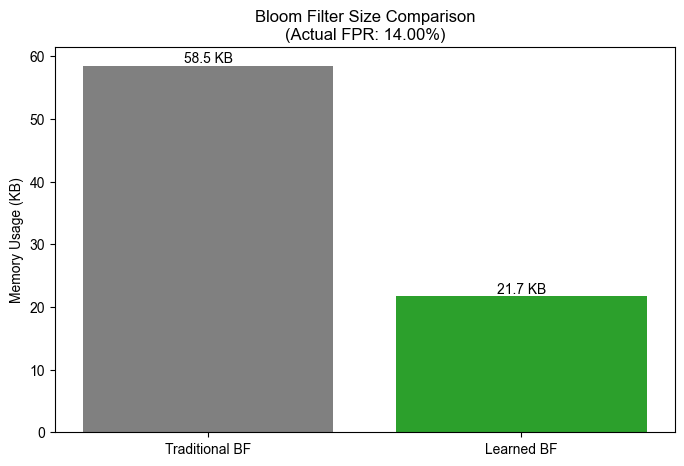

In [3]:
# ==========================================
# Section 5: Learned Bloom Filter 
# ==========================================
print("\n" + "="*50)
print("   SECTION 5: LEARNED BLOOM FILTER   ")
print("="*50)

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
# 引入必要的归一化工具
from sklearn.preprocessing import MinMaxScaler 

class LearnedBloomFilter:
    def __init__(self, threshold=0.6):
        """
        threshold: 阈值 tau。模型打分 > tau 视为存在。
        """
        self.threshold = threshold
        self.model = self._build_classifier()
        # 备用过滤器：存储模型漏掉的 False Negatives
        self.backup_filter = set()
        self.estimated_model_size = 0 # unit: bits
        
        # 定义归一化器，将 Key 缩放到 0-1 之间
        # 神经网络无法直接处理 0-1000万 这样的大整数
        self.scaler = MinMaxScaler()
        
    def _build_classifier(self):
        model = keras.Sequential([
            layers.Input(shape=(1,)), 
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(1, activation='sigmoid') # 输出 0~1 的概率
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def train(self, positives, negatives):
        """
        positives: 实际上存在的 Key
        negatives: 实际上不存在的 Key
        """
        print("1. Preprocessing Data (Scaling)...")
        # 转换为 numpy 格式
        positives = np.array(positives, dtype=np.float32)
        negatives = np.array(negatives, dtype=np.float32)
        
        # 训练归一化器 (拟合数据范围)
        all_data = np.concatenate([positives, negatives]).reshape(-1, 1)
        self.scaler.fit(all_data)
        
        # 归一化数据 (变成 0-1 之间)
        X_pos = self.scaler.transform(positives.reshape(-1, 1))
        X_neg = self.scaler.transform(negatives[:len(positives)].reshape(-1, 1)) # 负采样
        
        # 构造训练集
        y_pos = np.ones(len(X_pos))
        y_neg = np.zeros(len(X_neg))
        
        X = np.concatenate([X_pos, X_neg])
        y = np.concatenate([y_pos, y_neg])
        
        # 打乱数据
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]
        
        print("2. Training Classifier...")
        self.model.fit(X, y, epochs=10, batch_size=1024, verbose=0)
        
        # 3. 构建 Backup Filter
        print("3. Building Backup Filter...")
        # 预测所有 Positive Key
        preds = self.model.predict(X_pos, verbose=0).flatten()
        
        # 找出 False Negatives (被模型误判为不存在的)
        fn_indices = np.where(preds <= self.threshold)[0]
        
        # 注意：存入备用过滤器时要用原始 Key (整数)
        original_positives = positives.astype(np.int64)
        false_negatives = original_positives[fn_indices]
        
        for key in false_negatives:
            self.backup_filter.add(key)
            
        print(f"   Total Positives: {len(positives)}")
        print(f"   Model Missed (FN): {len(false_negatives)}")
        print(f"   Backup Filter Size: {len(self.backup_filter)} keys")
        
        # 估算模型权重大小
        total_weights = sum([np.prod(w.shape) for w in self.model.get_weights()])
        self.estimated_model_size = total_weights * 32 

    def contains(self, key):
        # 查询前必须先归一化
        key_arr = np.array([[key]], dtype=np.float32)
        key_scaled = self.scaler.transform(key_arr)
        
        pred = self.model.predict(key_scaled, verbose=0)[0][0]
        if pred > self.threshold:
            return True 
        
        # 查备用 (查原始 Key)
        if int(key) in self.backup_filter:
            return True
        return False

    def get_memory_usage_bits(self, target_fpr_backup=0.01):
        n = len(self.backup_filter)
        model_bits = self.estimated_model_size
        if n == 0: return model_bits
        # Bloom Filter 公式
        backup_bits = - (n * np.log(target_fpr_backup)) / (np.log(2)**2)
        return model_bits + backup_bits

def calc_optimal_bloom_filter_bits(n, p):
    return - (n * np.log(p)) / (np.log(2)**2)

# ==========================================
# Benchmark Execution
# ==========================================

# 1. 准备数据 (使用有规律的数据，模拟真实世界分布)
print("Generating Structured Data (Learnable Patterns)...")
# 我们构造一个分布：Key 集中在 0-40% 和 60-80% 的区间内
data_size = 1000000
all_data = np.arange(data_size)

mask_positive = ((all_data >= 0) & (all_data < 400000)) | \
                ((all_data >= 600000) & (all_data < 800000))

positive_keys = all_data[mask_positive]  # 存在的 Key
negative_keys = all_data[~mask_positive] # 不存在的 Key

# 打乱顺序
np.random.shuffle(positive_keys)
np.random.shuffle(negative_keys)

# 只取一部分进行快速演示 (例如 5万个)
N_TRAIN = 50000
train_positives = positive_keys[:N_TRAIN]
train_negatives = negative_keys[:N_TRAIN]

# 2. 训练
lbf = LearnedBloomFilter(threshold=0.6) 
lbf.train(train_positives, train_negatives)

# 3. 评估指标
TARGET_FPR = 0.01 
traditional_bits = calc_optimal_bloom_filter_bits(len(train_positives), TARGET_FPR)
learned_bits = lbf.get_memory_usage_bits(target_fpr_backup=TARGET_FPR)

# 4. 验证 FPR
print("\nMeasuring Actual False Positive Rate...")
# 用剩下的 Negative 数据测试
test_negatives = negative_keys[N_TRAIN:N_TRAIN+1000]
false_positives = 0
for k in test_negatives:
    if lbf.contains(k):
        false_positives += 1
actual_fpr = false_positives / len(test_negatives)
print(f"Actual FPR on Test Set: {actual_fpr:.4f}")

# 5. 结果对比
print(f"\n=== Final Memory Comparison ===")
print(f"Traditional Bloom Filter: {traditional_bits/8/1024:.2f} KB")
print(f"Learned Bloom Filter:     {learned_bits/8/1024:.2f} KB")
print(f"Space Saving:             {100 * (1 - learned_bits/traditional_bits):.2f}%")

plt.figure(figsize=(8, 5))
plt.bar(['Traditional BF', 'Learned BF'], 
        [traditional_bits/8/1024, learned_bits/8/1024], 
        color=['gray', '#2ca02c'])
plt.ylabel('Memory Usage (KB)')
plt.title(f'Bloom Filter Size Comparison\n(Actual FPR: {actual_fpr:.2%})')
for i, v in enumerate([traditional_bits/8/1024, learned_bits/8/1024]):
    plt.text(i, v, f"{v:.1f} KB", ha='center', va='bottom')
plt.show()